In [19]:
import os
import json

import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from itertools import chain

from comparison.wasserstein import emd

In [20]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib import rcParams

In [21]:
vill_fits = pd.read_csv('comparison/vill_fits_final.csv')

In [22]:
vill_fits

,vill_no,emd,sc,ho
0,1,0.104089,0.2500,0.3125
1,2,0.043333,0.5625,0.3750
2,3,0.037434,0.5000,0.3750
3,4,0.027399,0.5625,0.4375
4,5,0.044036,0.6250,0.6250
...,...,...,...,...
70,73,0.172987,0.0000,0.3125
71,74,0.092859,0.3750,0.3750
72,75,0.176602,0.0000,0.3750
73,76,0.122080,0.5000,0.5625


In [37]:
vill_mod_array = []
vill_num_array = []
sim_mod_array = []
sim_num_array = []

for index, row in vill_fits.iterrows():
    vill_no = int(row['vill_no'])
    sc = row['sc']
    ho = row['ho']
    
    stata_household = pd.read_stata('banerjee_data/datav4.0/Data/2. Demographics and Outcomes/household_characteristics.dta')

    trust_fact_files = ['visitcome','visitgo', 'templecompany', 'helpdecision', 'giveadvice', 'medic']

    stata_vill = stata_household.where(stata_household['village'] == vill_no).dropna(how = 'all')
    room_type = np.array(stata_vill['room_no']/np.sqrt((stata_vill['bed_no']+1))<=2)
    room_type_dict = {k: v for k, v in enumerate(room_type)}

    old_file3 = 'banerjee_data/datav4.0/Data/1. Network Data/Adjacency Matrices/adj_' + trust_fact_files[0] +'_HH_vilno_' + str(vill_no) + '.csv'
    ad_mat_old3 = (pd.read_csv(old_file3, header=None)).to_numpy()

    for file in trust_fact_files[1:]:
        new_file3 = 'banerjee_data/datav4.0/Data/1. Network Data/Adjacency Matrices/adj_' + file +'_HH_vilno_' + str(vill_no) + '.csv'
        ad_mat_new3= (pd.read_csv(new_file3, header=None)).to_numpy()

        ad_mat_old3 = np.bitwise_or(ad_mat_old3, ad_mat_new3)

    vill_mat = ad_mat_old3
    
    data_dir = 'finer_results_ntwk'
    filename = '{odir}/{vill_no}_{k}_{sc}_{ho}_losses.txt'.format(
        odir=data_dir, vill_no=str(vill_no), k = str(k), sc = str(sc), ho = str(ho))

    f = open(filename, "r")

    # nonsense code for reading the simulated networks and attrs
    ntwk = f.readline()
    attrs = f.readline()
    ntwk = ntwk.replace('[', '')
    ntwk = ntwk.replace(']', '')
    ntwk = ntwk.replace("'", '')
    num_nodes = int(np.sqrt((ntwk.count('0.0') + ntwk.count('1.0'))/5))
    ntwk_arr = np.array([int(float(e)) for e in ntwk.split(',')])
    arr1 = ntwk_arr[:num_nodes**2].reshape((num_nodes, num_nodes))
    arr2 = ntwk_arr[num_nodes**2:2*num_nodes**2].reshape((num_nodes, num_nodes))
    arr3 = ntwk_arr[2*num_nodes**2:3*num_nodes**2].reshape((num_nodes, num_nodes))
    arr4 = ntwk_arr[3*num_nodes**2:4*num_nodes**2].reshape((num_nodes, num_nodes))
    arr5 = ntwk_arr[4*num_nodes**2:5*num_nodes**2].reshape((num_nodes, num_nodes))

    attrs = attrs.strip('{}\n')
    pairs = attrs.split(',')
    attr_dict = {int(key): int(value) for key, value in (pair.split(': ') for pair in pairs)}

    #sim_dists = [ calc_dists(a, attr_dict, k) for a in [arr1, arr2, arr3, arr4, arr5] ]
    #avg_sim_dists = avg_dists(sim_dists)
    #vill_dist = calc_dists(vill_mat, room_type_dict, kappa_vill)

    #sim_tri_count = np.mean([ triangle_count(np.array(a)) for a in [arr1, arr2, arr3, arr4, arr5] ])
    #sim_assort = np.mean([ assortativity_coeff(np.array(a), attr_dict) for a in [arr1, arr2, arr3, arr4, arr5] ])

    #vill_tri_count = triangle_count(vill_mat)
    #vill_assort = assortativity_coeff(vill_mat, room_type_dict)
    
    G_vill = nx.from_numpy_array(vill_mat)
    
    vill_communities = nx.community.louvain_communities(G_vill)
    
    vill_mod = nx.community.modularity(G_vill, vill_communities)
    
    vill_mod_array.append(vill_mod)
    
    num_vill = len(vill_communities)
    
    vill_num_array.append(num_vill)
    
    sim_Gs = [nx.from_numpy_array(a) for a in [arr1, arr2, arr3, arr4, arr5]]
    
    sim_comms = [nx.community.louvain_communities(g) for g in sim_Gs]
    
    num_sim = np.mean([len(comm) for comm in sim_comms])
    
    sim_zip = list(zip(sim_Gs, sim_comms))
    
    sim_mod = np.mean([nx.community.modularity(g_vill[0], g_vill[1]) for g_vill in sim_zip])
    
    sim_mod_array.append(sim_mod)
    
    sim_num_array.append(num_sim)


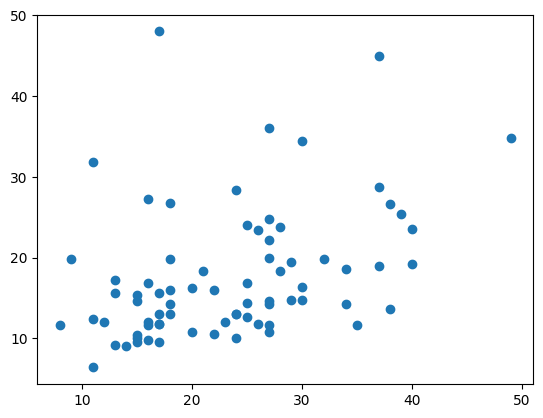

In [39]:
import matplotlib.pyplot as plt

plt.scatter(vill_num_array, sim_num_array)

(array([ 3.,  2., 10., 14., 13., 14., 10.,  5.,  2.,  2.]),
 array([0.36374878, 0.39057955, 0.41741032, 0.44424109, 0.47107187,
        0.49790264, 0.52473341, 0.55156418, 0.57839495, 0.60522572,
        0.6320565 ]),
 <BarContainer object of 10 artists>)

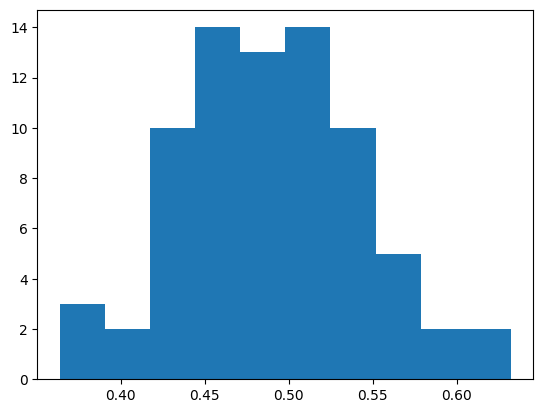

In [47]:
plt.hist(vill_mod_array, 10)

(array([ 4.,  6.,  8., 16., 18., 10.,  2.,  4.,  4.,  3.]),
 array([0.37165129, 0.42049239, 0.46933349, 0.51817459, 0.56701569,
        0.61585679, 0.66469789, 0.71353899, 0.76238009, 0.81122119,
        0.86006229]),
 <BarContainer object of 10 artists>)

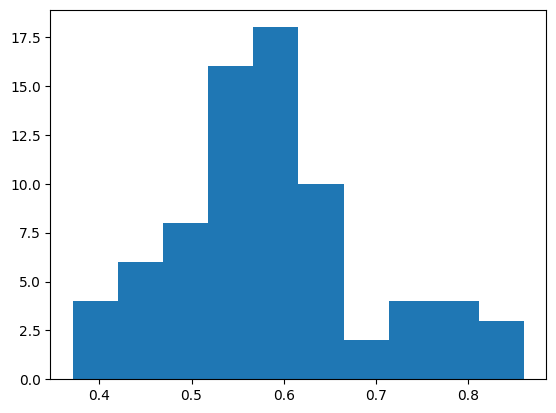

In [48]:
plt.hist(sim_mod_array, 10)